# Fuente: Ministerio de Sanidad

### Basada en la notificación diaria de casos agregados de COVID-19 al Ministerio de Sanidad

### https://covid19.isciii.es/resources/serie_historica_acumulados.csv

# Análisis exploratorio de los datos del COVID-19

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import urllib
import datetime
import time
from scipy.ndimage.filters import gaussian_filter1d

# Importación y tratamiento de los datos

## Leer datos desde csv del Ministerio de Sanidad

In [12]:
#Descargamos el CSV del Ministerio de Sanidad
url = "https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
#url = "datos_COVID-19.csv"
data_raw = pd.read_csv(url, encoding = "ISO-8859-1")
print(f"Fichero descargado con {data.shape[0]} registros")

Fichero descargado con 836 registros


## Guardarlos en fichero csv

In [13]:
if data_raw.shape[0] > 0:
    data_raw.to_csv('datos_COVID-19.csv')
    print(f"Fichero guardado con {data_raw.shape[0]} registros")
else:
     print(r'El fichero no se ha podido guardar correctamente' )

Fichero guardado con 1029 registros


## Tratamiento de los datos y creación de nuevas variables

In [25]:
data = data_raw

#Establecemos los nulos a 0
data.fillna({'CASOS': 0}, inplace=True)
data.fillna({'Hospitalizados': 0}, inplace=True)
data.fillna({'UCI': 0}, inplace=True)
data.fillna({'Fallecidos': 0}, inplace=True)
data.fillna({'Recuperados': 0}, inplace=True)


data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y')
data['CASOS'] = data['CASOS'].astype(int)
data['Hospitalizados'] = data['Hospitalizados'].astype(int)
data['UCI'] = data['UCI'].astype(int)
data['Fallecidos'] = data['Fallecidos'].astype(int)
data['Recuperados'] = data['Recuperados'].astype(int)


#Ordenamos los datos por pais y dia
data = data.sort_values(by=['CCAA', 'FECHA'], ascending=True)

data['CASOS-1'] = data['CASOS'].shift(1)
data['Hospitalizados-1'] = data['Hospitalizados'].shift(1)
data['UCI-1'] = data['UCI'].shift(1)
data['Fallecidos-1'] = data['Fallecidos'].shift(1)
data['Recuperados-1'] = data['Recuperados'].shift(1)

data['CASOSN'] = data['CASOS'] - data['CASOS-1']
data['HospitalizadosN'] = data['Hospitalizados'] - data['Hospitalizados-1']
data['UCIN'] = data['UCI'] - data['UCI-1']
data['FallecidosN'] = data['Fallecidos'] - data['Fallecidos-1']
data['RecuperadosN'] = data['Recuperados'] - data['Recuperados-1']


data['CASOS-4'] = data['CASOS'].shift(4)
data['Ratio4'] = data['CASOS']/data['CASOS-4']


data = data[(data['FECHA'] >= '2020-03-01')]

data = data.sort_values(by=['CASOS'], ascending=False)

dataES = data.groupby(['FECHA']).agg({'CASOS':'sum', 'Hospitalizados':'sum', 'UCI':'sum', 'Fallecidos':'sum', 'Recuperados':'sum', 'CASOSN':'sum', 'HospitalizadosN':'sum', 'UCIN':'sum', 'FallecidosN':'sum', 'RecuperadosN':'sum'}).reset_index()
dataES['CASOS-4'] = dataES['CASOS'].shift(4)
dataES['Ratio4'] = dataES['CASOS']/dataES['CASOS-4']

# Casos diarios COVID-19 en España

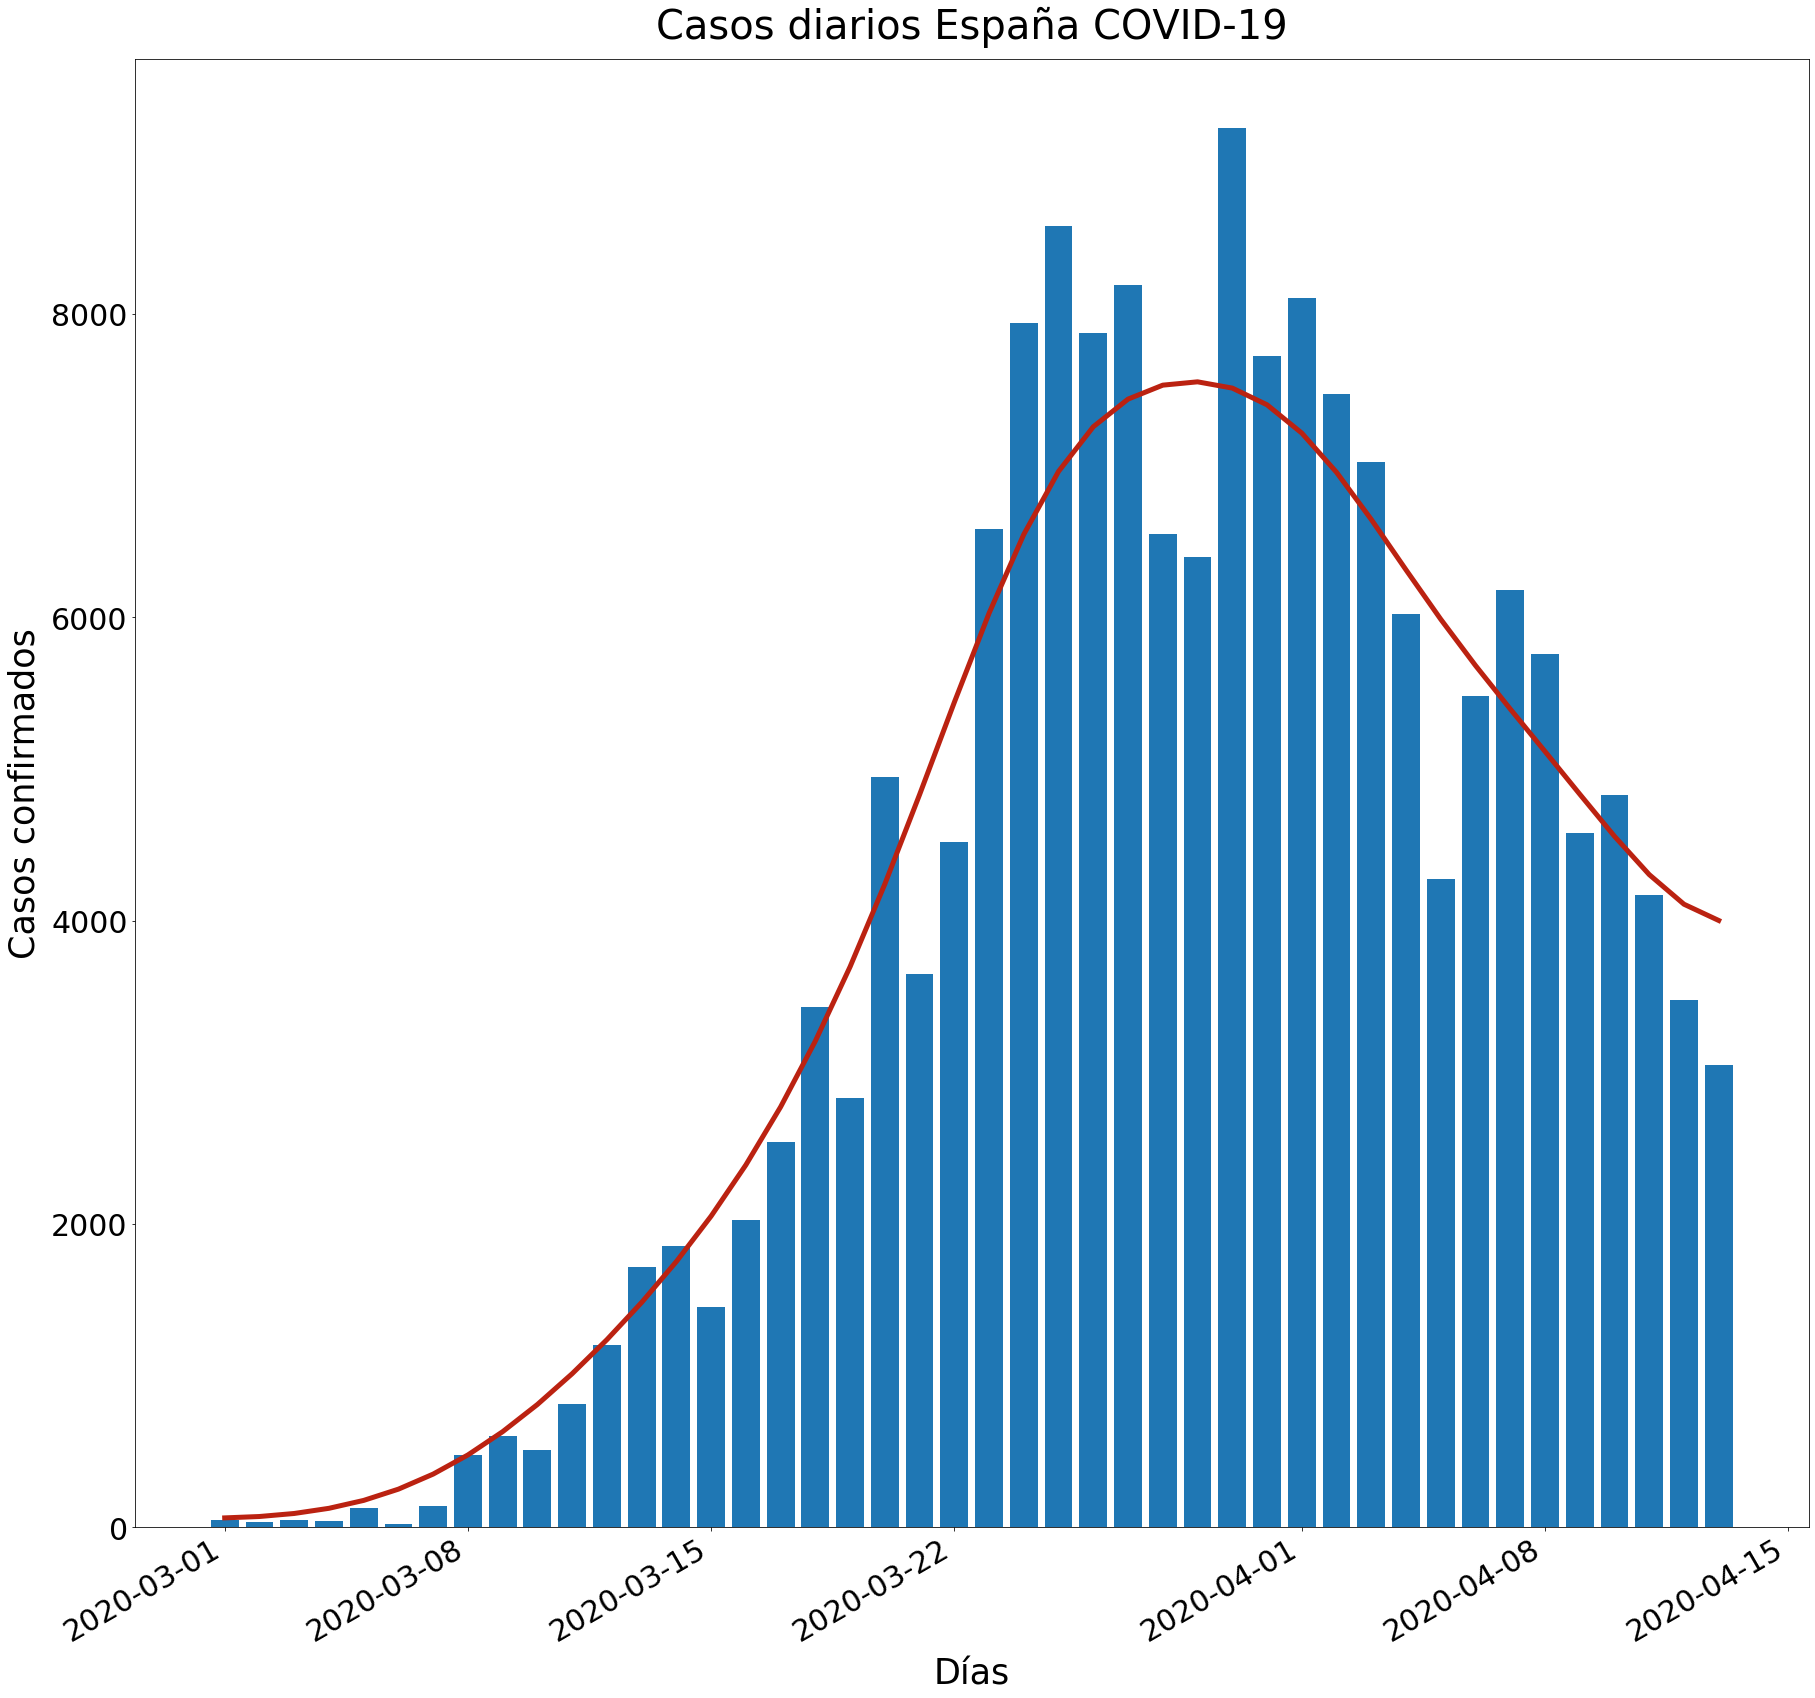

In [38]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(dataES['FECHA'], dataES['CASOSN'])
plt.plot(dataES['FECHA'], gaussian_filter1d(dataES['CASOSN'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosES.jpg", bbox_inches = "tight")

plt.show()

# Ratio de contagio cada 4 días

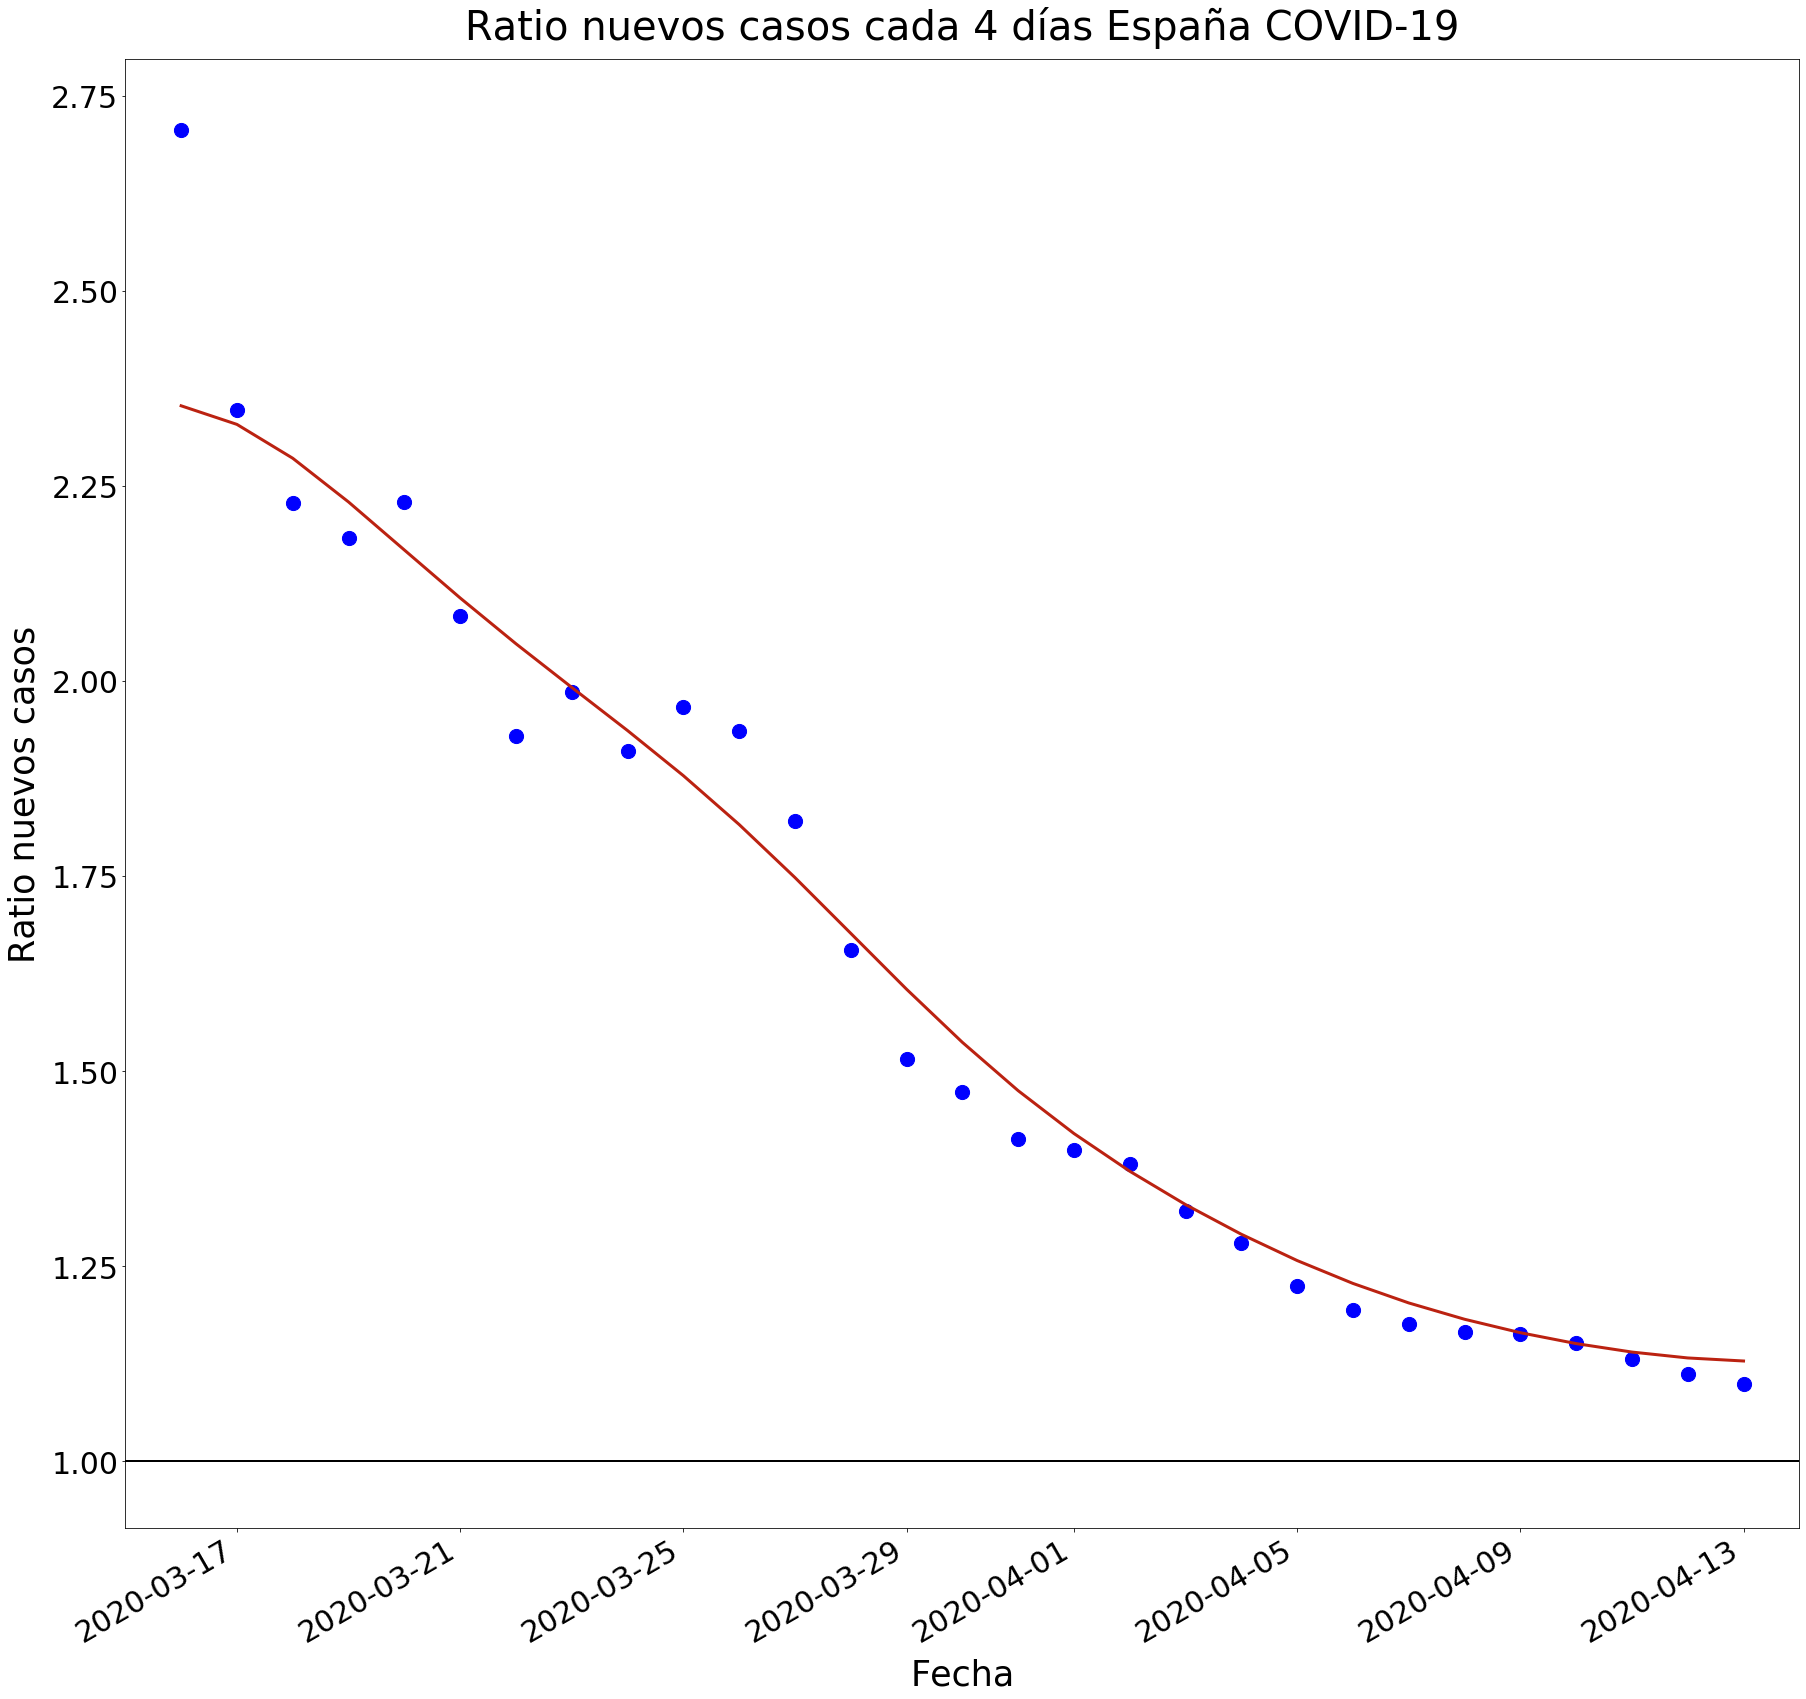

In [39]:
fig, ax =plt.subplots(figsize=(30,30))

dataES2 = dataES[(dataES['FECHA']>'2020-03-15')]

plt.scatter(dataES2['FECHA'], dataES2['Ratio4'],c='b',s=200)
plt.plot(dataES2['FECHA'], gaussian_filter1d(dataES2['Ratio4'], sigma=3),linewidth=3, color = '#BB2211')

ax.set_xlim(np.min(dataES2['FECHA'])-datetime.timedelta(days=1), np.max(dataES2['FECHA'])+ datetime.timedelta(days=1))
ax.axhline(linewidth=2, color='black', y=1)
fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Fecha", fontsize=35, labelpad=10)
plt.ylabel("Ratio nuevos casos", fontsize=35, labelpad=10)
plt.title("Ratio nuevos casos cada 4 días España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("RatioCasosES.jpg", bbox_inches = "tight")

plt.show()

# Evolución diaria del COVID-19 en España según situación clinica

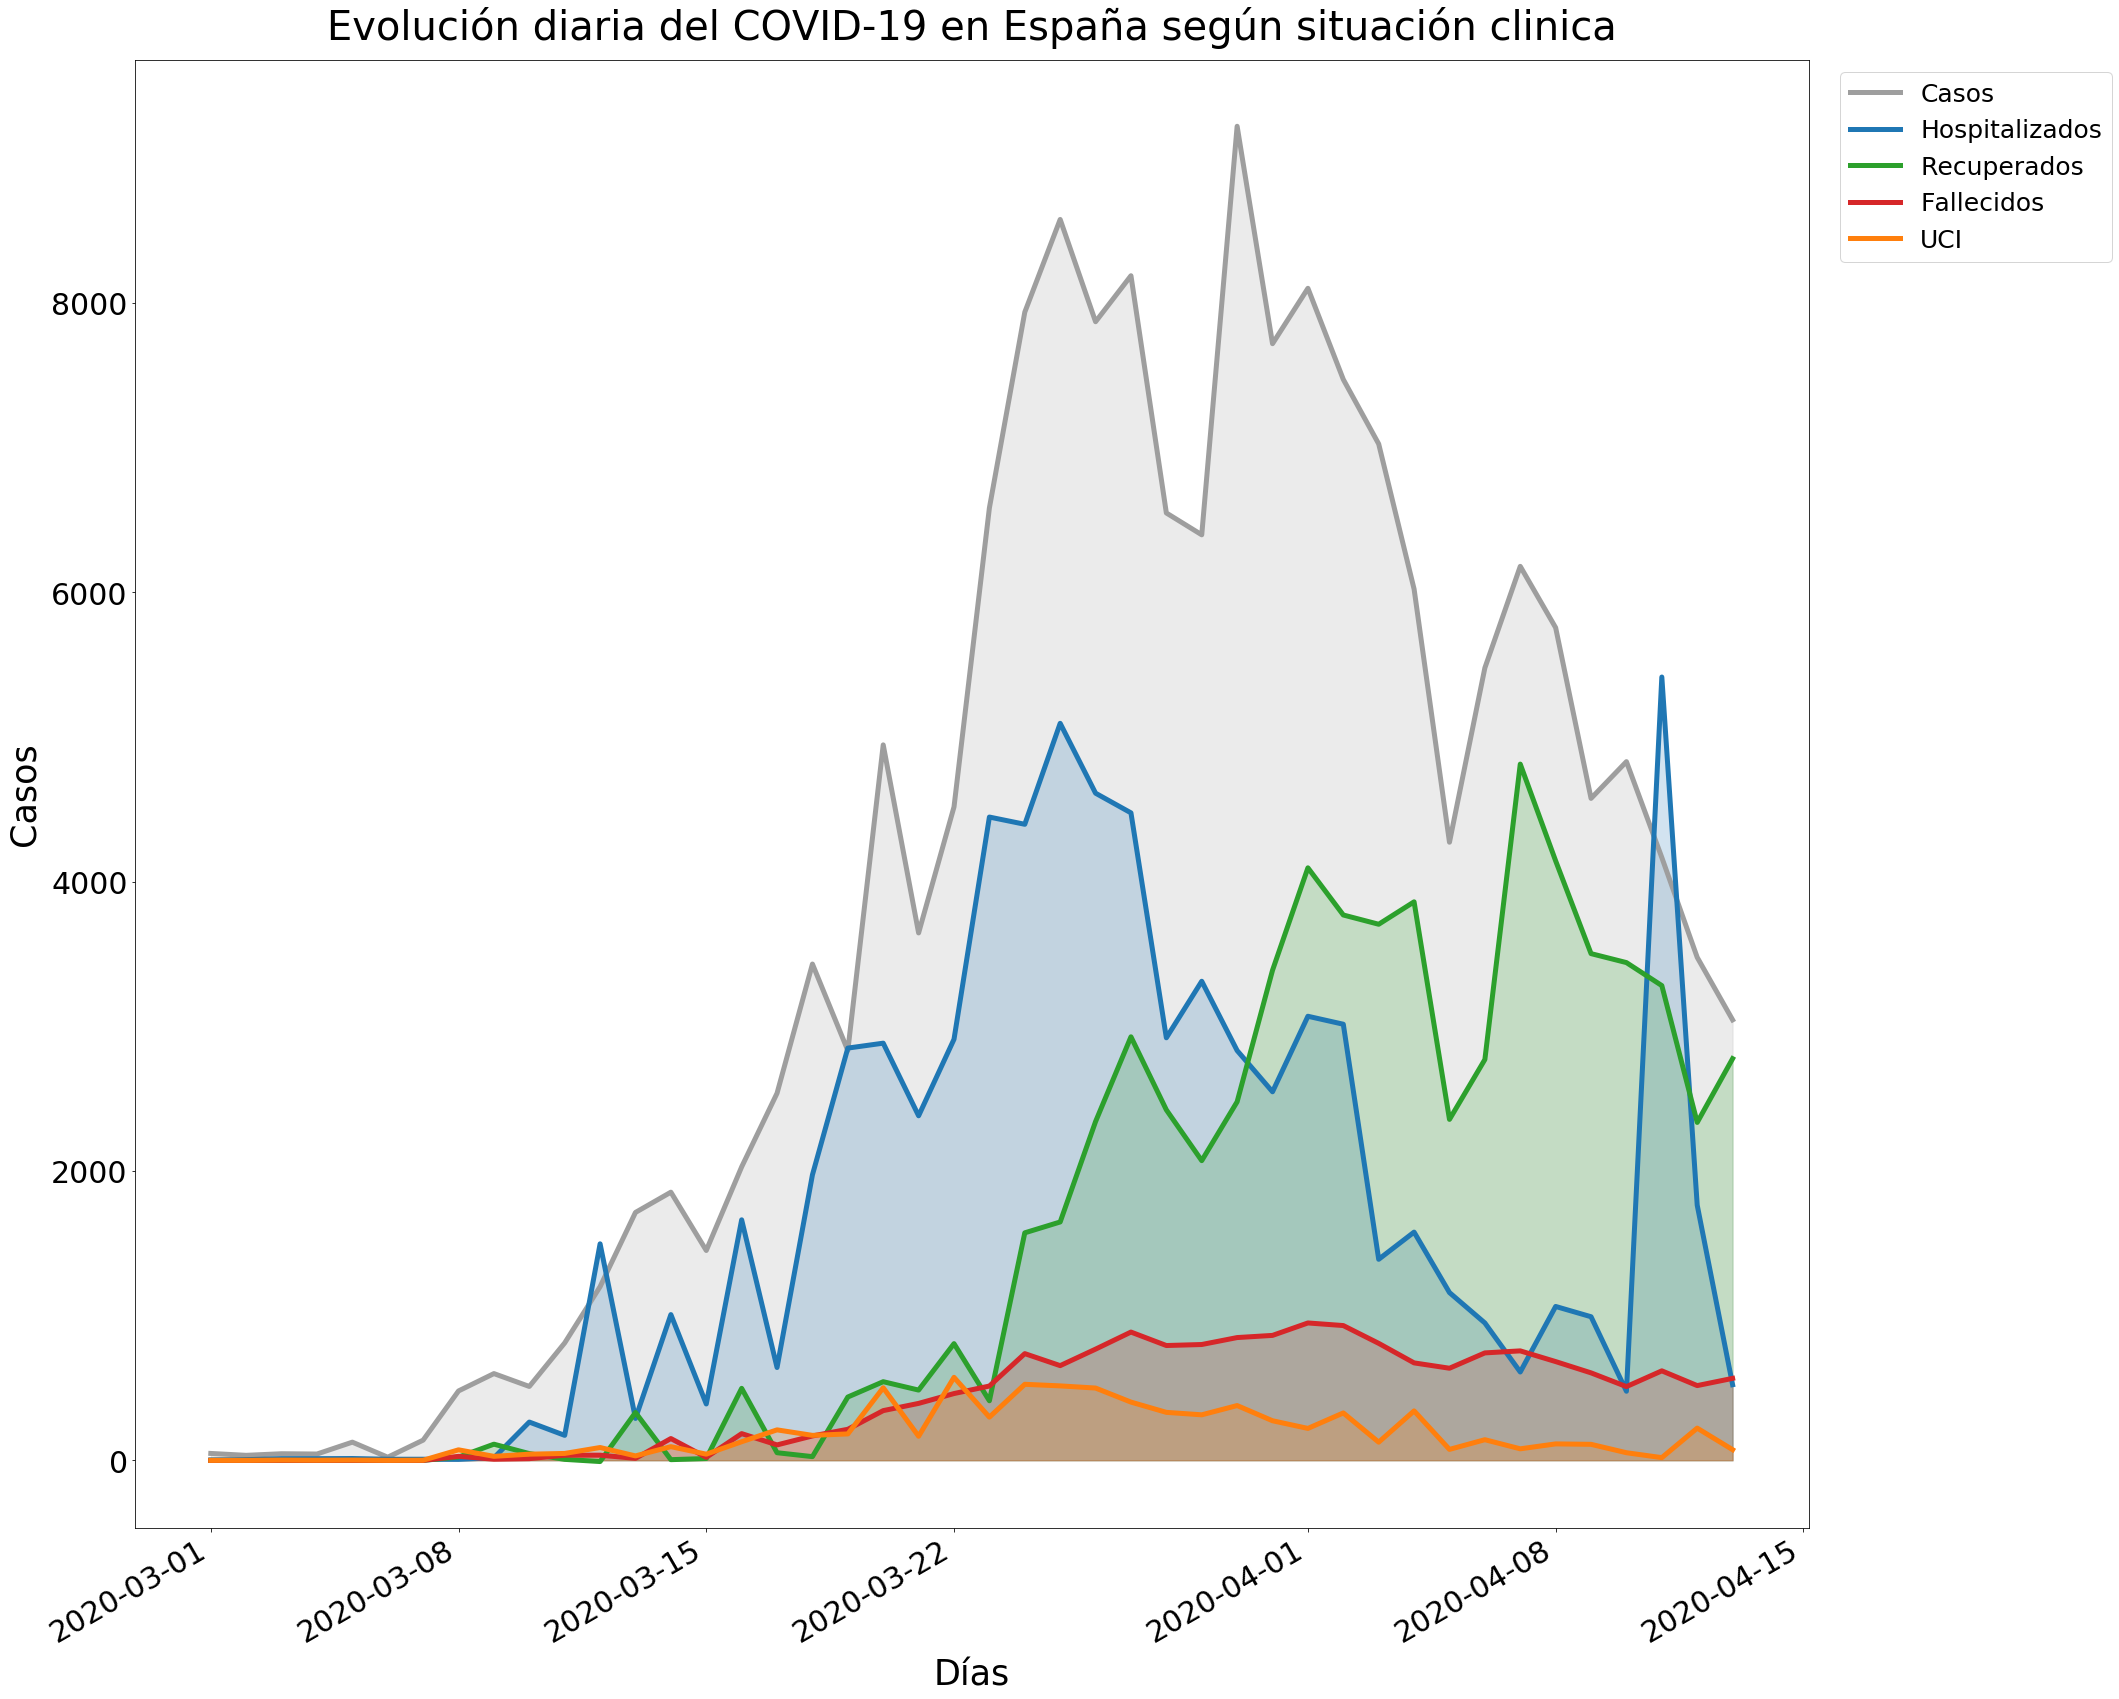

In [40]:
fig, ax =plt.subplots(figsize=(30,30))

plt.plot(dataES['FECHA'], dataES['CASOSN'], label = 'Casos', linewidth=5, color = '#9E9E9E')
plt.fill_between(dataES['FECHA'], dataES['CASOSN'], color = '#9E9E9E', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['HospitalizadosN'], label = 'Hospitalizados', linewidth=5, color = '#1f77b4')
plt.fill_between(dataES['FECHA'], dataES['HospitalizadosN'], color = '#1f77b4', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['RecuperadosN'], label = 'Recuperados', linewidth=5, color = '#2ca02c')
plt.fill_between(dataES['FECHA'], dataES['RecuperadosN'], color = '#2ca02c', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['FallecidosN'], label = 'Fallecidos', linewidth=5, color = '#d62729')
plt.fill_between(dataES['FECHA'], dataES['FallecidosN'], color = '#d62729', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['UCIN'], label = 'UCI', linewidth=5, color = '#ff7f0d')
plt.fill_between(dataES['FECHA'], dataES['UCIN'], color = '#ff7f0d', alpha=0.2)

fig.autofmt_xdate()

plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Evolución diaria del COVID-19 en España según situación clinica", fontsize=40, loc='center', pad=20)
plt.savefig("EvoluciónDiariaESClinica.jpg", bbox_inches = "tight")
plt.show()

# Evolución acumulada del COVID-19 en España según situación clinica

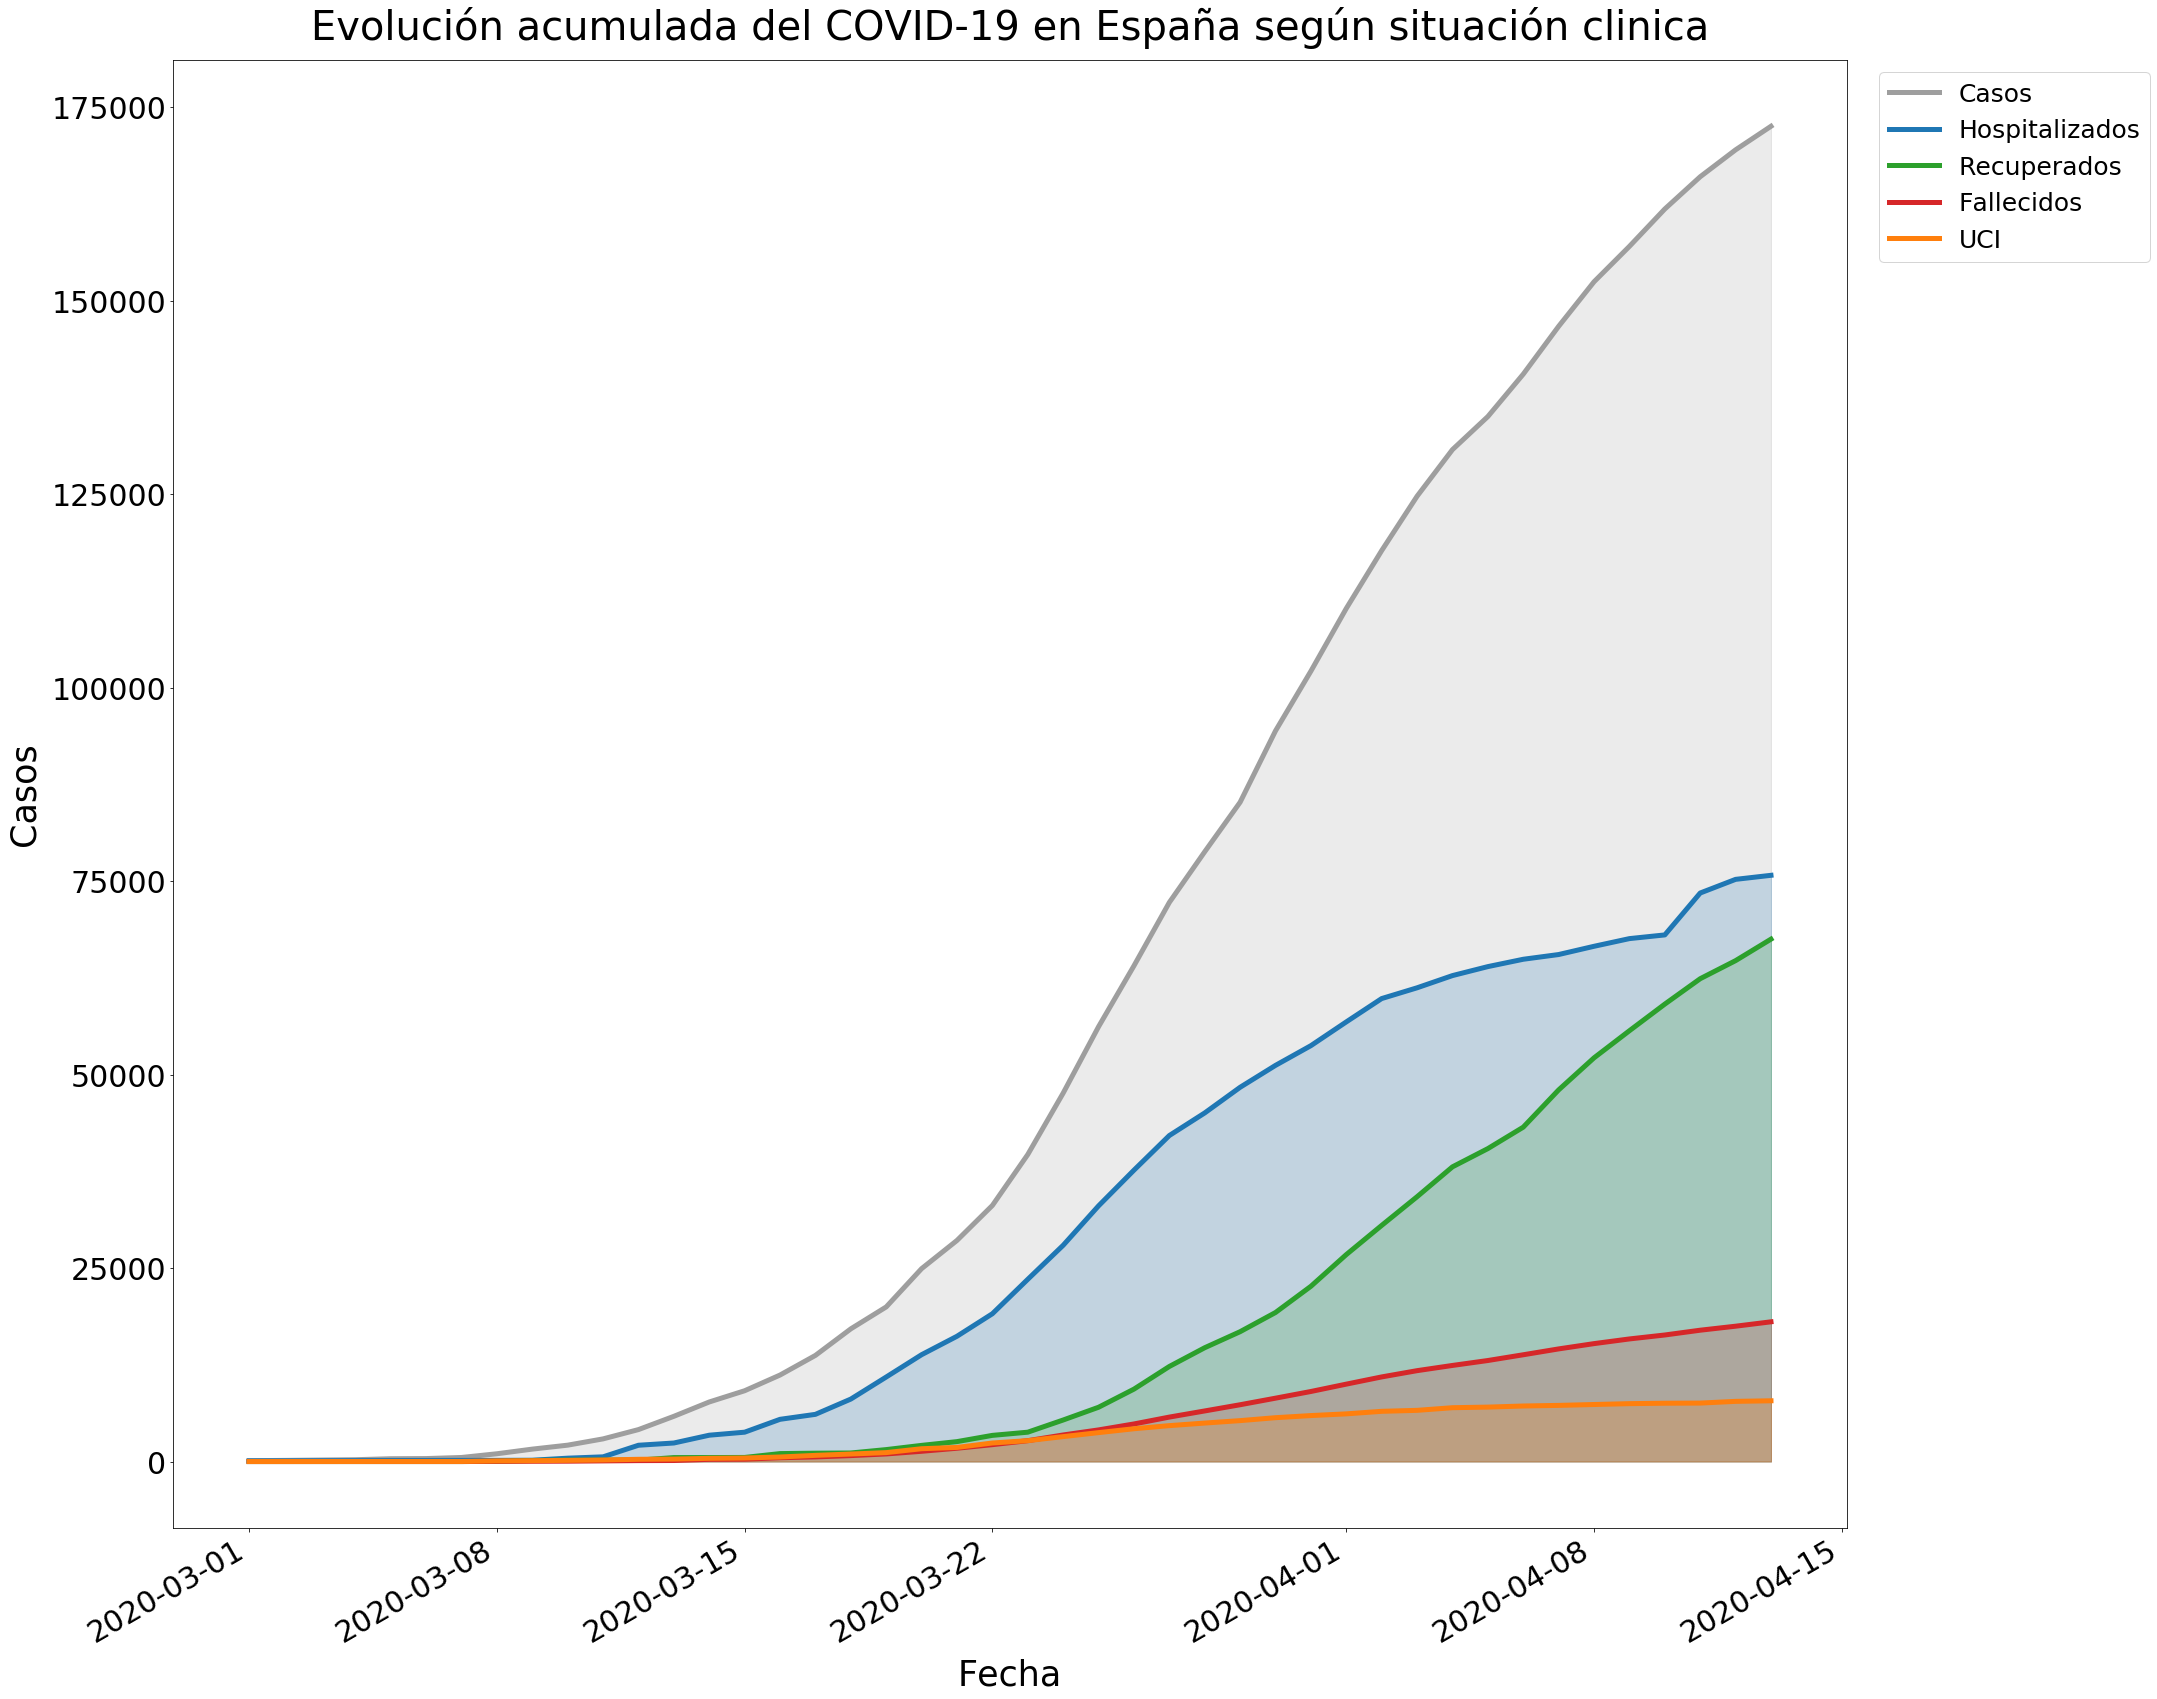

In [41]:
fig, ax =plt.subplots(figsize=(30,30))

plt.plot(dataES['FECHA'], dataES['CASOS'], label = 'Casos', linewidth=5, color = '#9E9E9E')
plt.fill_between(dataES['FECHA'], dataES['CASOS'], color = '#9E9E9E', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['Hospitalizados'], label = 'Hospitalizados', linewidth=5, color = '#1f77b4')
plt.fill_between(dataES['FECHA'], dataES['Hospitalizados'], color = '#1f77b4', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['Recuperados'], label = 'Recuperados', linewidth=5, color = '#2ca02c')
plt.fill_between(dataES['FECHA'], dataES['Recuperados'], color = '#2ca02c', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['Fallecidos'], label = 'Fallecidos', linewidth=5, color = '#d62729')
plt.fill_between(dataES['FECHA'], dataES['Fallecidos'], color = '#d62729', alpha=0.2)
plt.plot(dataES['FECHA'], dataES['UCI'], label = 'UCI', linewidth=5, color = '#ff7f0d')
plt.fill_between(dataES['FECHA'], dataES['UCI'], color = '#ff7f0d', alpha=0.2)

fig.autofmt_xdate()

plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Fecha", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Evolución acumulada del COVID-19 en España según situación clinica", fontsize=40, loc='center', pad=20)
plt.savefig("EvoluciónESClinica.jpg", bbox_inches = "tight")
plt.show()

## Porcentaje casos totales acumulados COVID-19

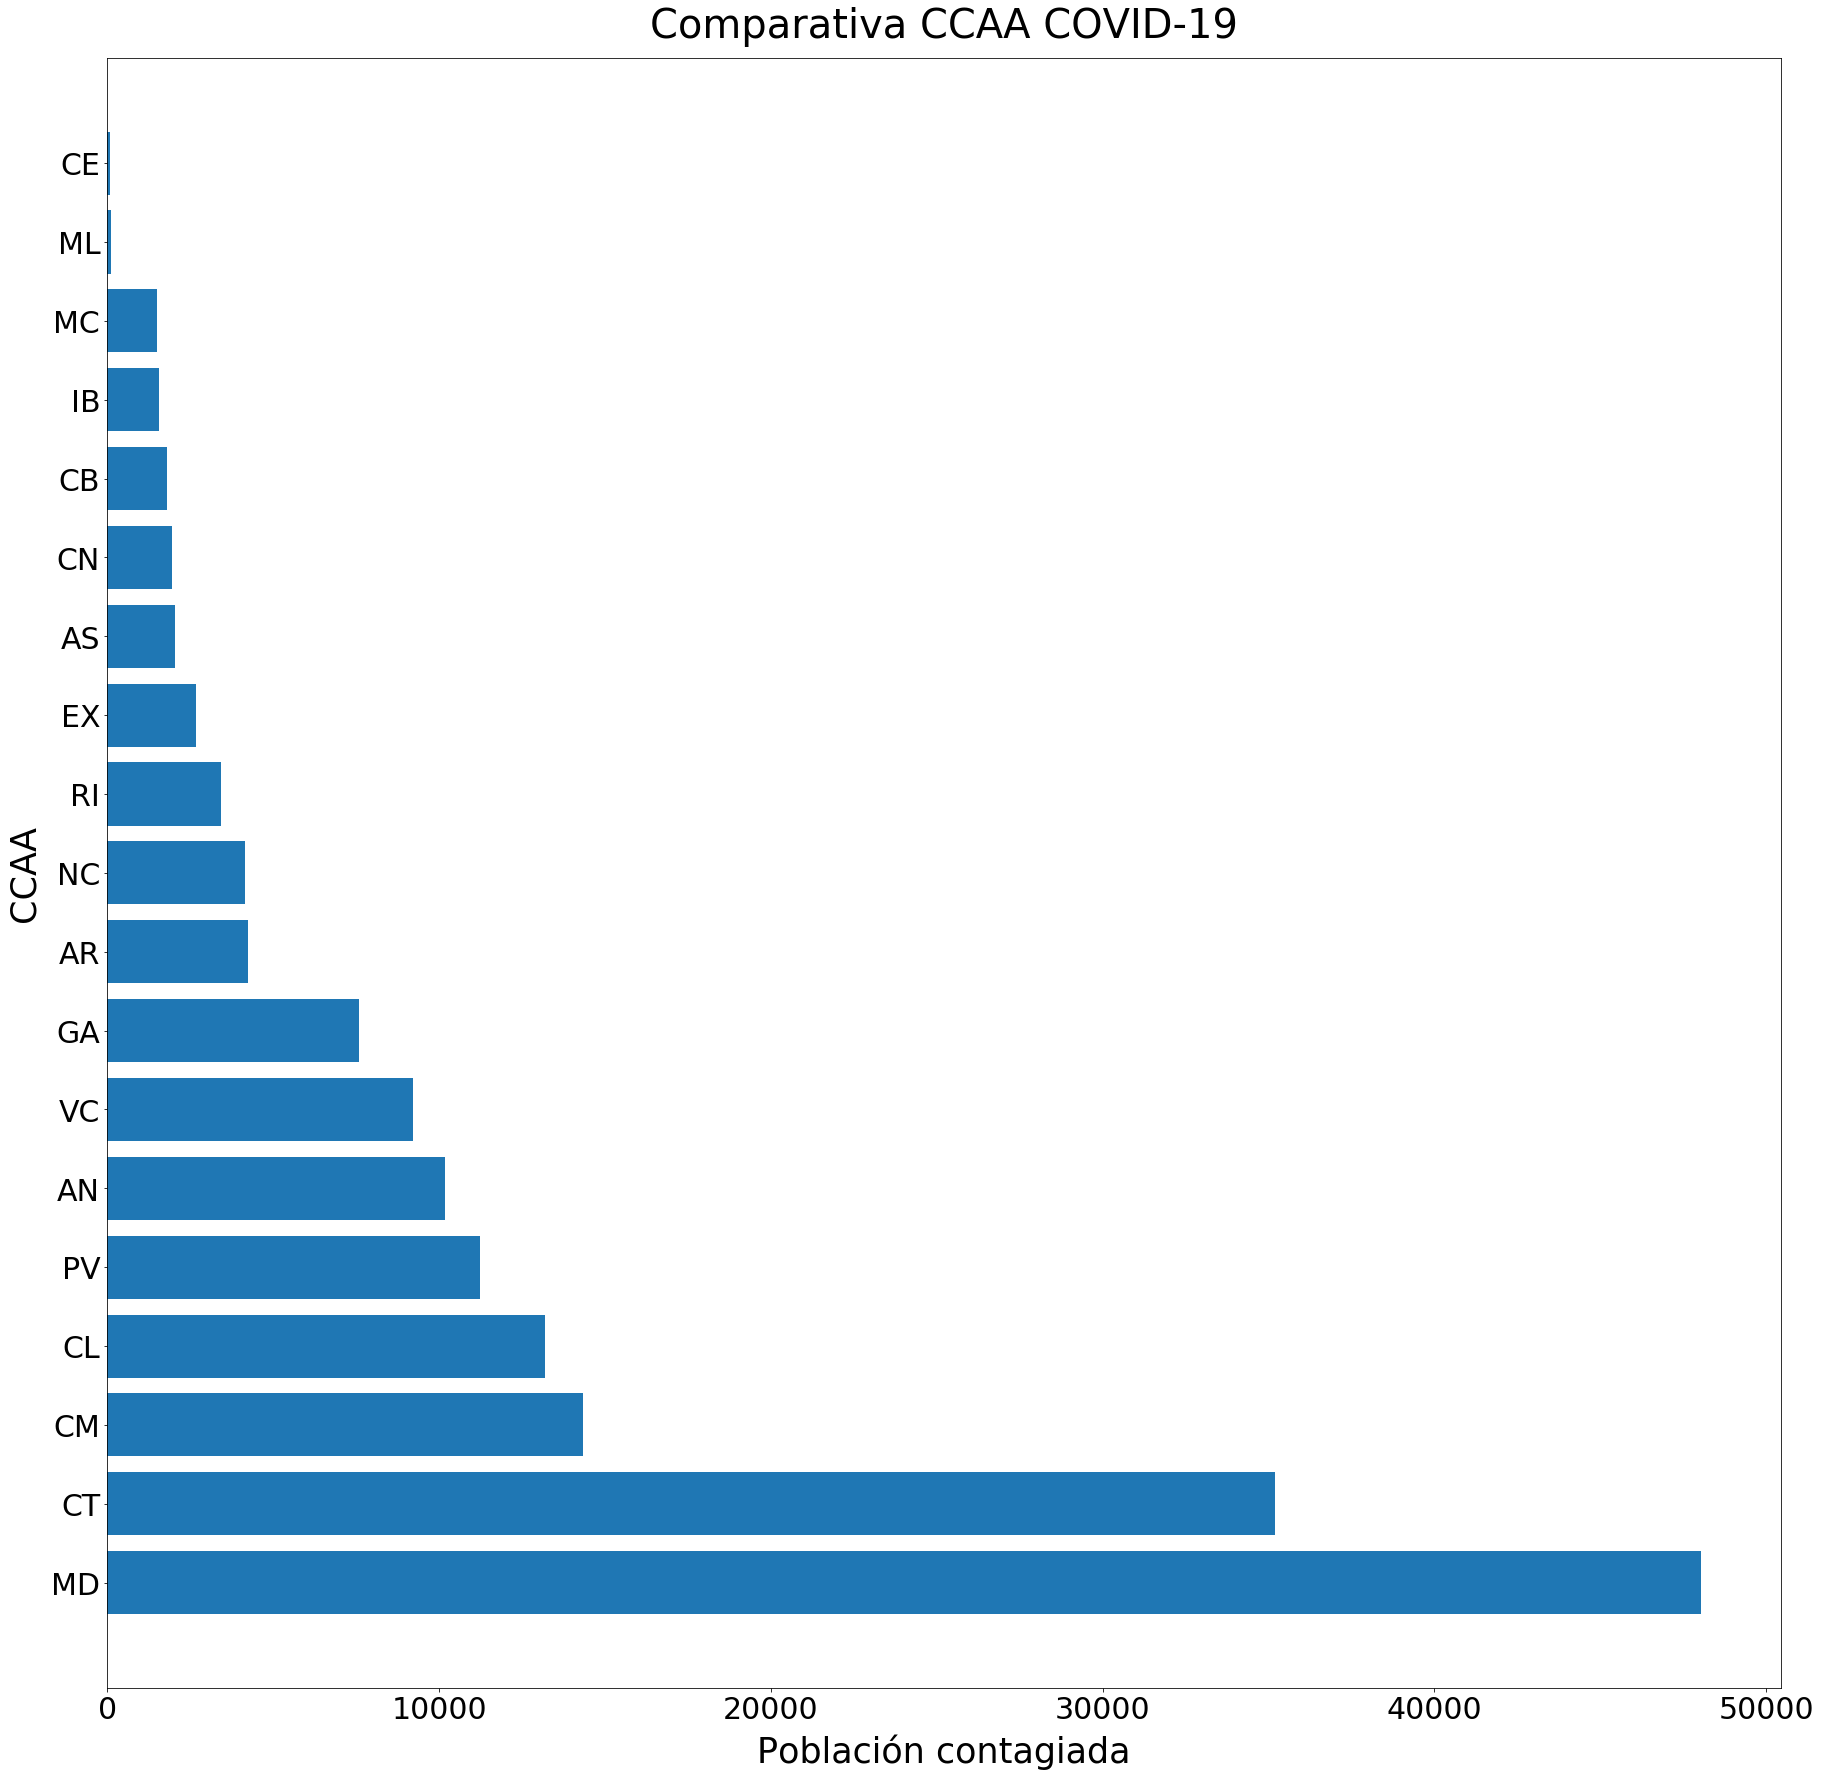

In [42]:
plt.subplots(figsize=(30,30))

plt.barh(data['CCAA'], data['CASOS'])

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Población contagiada", fontsize=35, labelpad=10)
plt.ylabel("CCAA", fontsize=35, labelpad=10)
plt.title("Comparativa CCAA COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("ComparativaCCAA.jpg", bbox_inches = "tight")

plt.show()